In [37]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.maxent_solver import JAXSolverConfig

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# --- Variables ---
variables = [
    ContinuousVariable(name="gdp_growth",    description="Annual GDP growth rate (%)", lower_bound=-2.0, upper_bound=8.0, unit="%"),
]

# --- Estimates (marginal + conditional cross-links) ---
estimates = [
    # Marginal: E[GDP growth] = 2.5%
    ExpectationEstimate(id="e_gdp", variable="gdp_growth", expected_value=2.5),
    # Marginal: P(GDP > 6%) = 0.45
    ProbabilityEstimate(
        id="p_gdp_high",
        proposition=InequalityProposition(variable="gdp_growth", 
                                          variable_type="continuous", 
                                          threshold=4.0, 
                                          is_lower_bound=True),
        probability=0.4,
    ),
]

print(f"{len(variables)} variables, {len(estimates)} estimates")

1 variables, 2 estimates


In [65]:
config = JAXSolverConfig(
    num_chains=256,
    num_iterations=1000,
    mcmc_steps_per_iteration=4,
    learning_rate=0.01,

    l2_regularization=1e-4,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config)

# Build for GDP growth (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="gdp_growth")

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

Prior means: [0.5]
Prior stds: [0.25]
Is Gaussian: [1.]
Prior alpha: [1.]
Prior beta: [1.]
Is Beta: [0.]
[MaxEntSolver] iter   50  max_err=0.055647  mean_err=0.042311  mean_squared_err=0.001968  accept=0.959  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.067450  mean_err=0.037132  mean_squared_err=0.002298  accept=0.678  step_size=0.35984
[MaxEntSolver] iter  150  max_err=0.053426  mean_err=0.040272  mean_squared_err=0.001795  accept=0.509  step_size=0.33801
[MaxEntSolver] iter  200  max_err=0.045218  mean_err=0.033784  mean_squared_err=0.001272  accept=0.576  step_size=0.31750
[MaxEntSolver] iter  250  max_err=0.060783  mean_err=0.033950  mean_squared_err=0.001873  accept=0.656  step_size=0.32964
[MaxEntSolver] iter  300  max_err=0.042253  mean_err=0.035178  mean_squared_err=0.001288  accept=0.667  step_size=0.30964
[MaxEntSolver] iter  350  max_err=0.041663  mean_err=0.031825  mean_squared_err=0.001110  accept=0.735  step_size=0.29086
[MaxEntSolver] iter  400  max_err=0.05145

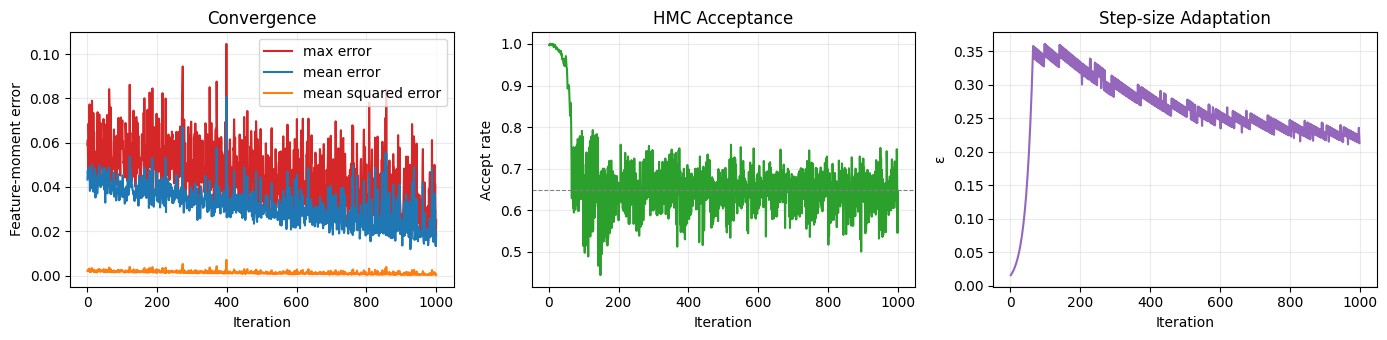

Final max error:  0.02504
Final mean error: 0.01874
Final accept rate: 0.646


In [66]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].plot(history["iteration"], history["mean_squared_error"], label="mean squared error", color="C1")

axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [67]:
import jax.numpy as jnp
energy = builder.solver._energy_fn
theta = info['theta']

x = np.linspace(0, 1, 200)[1:-1]
x_e = jnp.array([energy(theta, xi) for xi in x.reshape(-1, 1)])

px = jnp.exp(-x_e)
px = px / jnp.sum(px) * len(px)  # normalise

feature_fn = builder.solver._batch_feature_fn
features = feature_fn(builder.solver._buffer.states)

In [68]:
print(np.mean(features, axis=0))
print('expected', builder.solver._feature_targets)

[0.46243623 0.37495744]
expected [0.45 0.4 ]


In [69]:
samples = info["energy_model"].sample(10000)

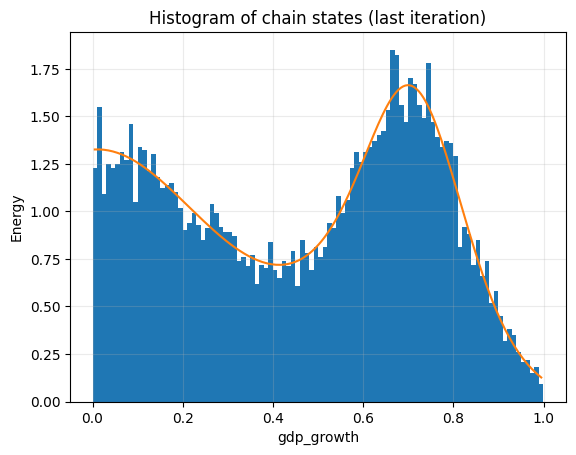

In [70]:
plt.plot(x, px, color="C1")
plt.xlabel("GDP Growth (%)"); plt.ylabel("Energy"); plt.title("Energy Function")

plt.hist(samples[:, 0], bins=100, density=True)
plt.xlabel("gdp_growth"); plt.title("Histogram of chain states (last iteration)"); plt.grid(alpha=0.25); plt.show()